In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
#from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    #plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
def bin_spectrum(wl, flux, error, mask, binh, weight=False):

    """Bin low S/N 1D data from xshooter
    ----------
    flux : np.array containing 2D-image flux
        Flux in input image
    error : np.array containing 2D-image error
        Error in input image
    binh : int
        binning along x-axis
    Returns
    -------
    binned fits image
    """

    print("Binning image by a factor: "+str(binh))
    if binh == 1:
        return wl, flux, error, mask

    # Outsize
    size = flux.shape[0]
    outsize = int(np.round(size/binh))

    # Containers
    wl_out = np.zeros((outsize))
    res = np.zeros((outsize))
    reserr = np.zeros((outsize))
    resbp = np.zeros((outsize))

    for ii in np.arange(0, size - binh, binh):
        # Find psotions in new array
        h_slice = slice(ii, ii + binh)
        h_index = int((ii + binh)/binh) - 1
        # Construct weighted average and weighted std along binning axis
        res[h_index], reserr[h_index], resbp[h_index] = avg(flux[ii:ii + binh], error[ii:ii + binh], mask = mask[ii:ii + binh], axis=0, weight=weight)
        wl_out[h_index] = np.median(wl[ii:ii + binh], axis=0)

    return wl_out[1:-1], res[1:-1], reserr[1:-1], resbp[1:-1]


def avg(flux, error, mask=None, axis=2, weight=False, weight_map=None):

    """Calculate the weighted average with errors
    ----------
    flux : array-like
        Values to take average of
    error : array-like
        Errors associated with values, assumed to be standard deviations.
    mask : array-like
        Array of bools, where true means a masked value.
    axis : int, default 0
        axis argument passed to numpy
    Returns
    -------
    average, error : tuple
    Notes
    -----
    """
    try:
        if not mask:
            mask = np.zeros_like(flux).astype("bool")
    except:
        pass
        # print("All values are masked... Returning nan")
        # if np.sum(mask.astype("int")) == 0:
        #     return np.nan, np.nan, np.nan


    # Normalize to avoid numerical issues in flux-calibrated data
    norm = abs(np.median(flux[flux > 0]))
    if norm == np.nan or norm == np.inf or norm == 0:
        print("Nomalization factor in avg has got a bad value. It's "+str(norm)+" ... Replacing with 1")

    flux_func = flux.copy() / norm
    error_func = error.copy() / norm

    # Calculate average based on supplied weight map
    if weight_map is not None:

        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # https://physics.stackexchange.com/questions/15197/how-do-you-find-the-uncertainty-of-a-weighted-average?newreg=4e2b8a1d87f04c01a82940d234a07fc5
        average = np.sum(flux_func * weight_map, axis = axis) / np.sum(weight_map, axis = axis)
        variance = np.sum(error_func**2 * weight_map**2, axis = axis) / np.sum(weight_map, axis = axis)**2



    # Inverse variance weighted average
    elif weight:
        ma_flux_func = np.ma.array(flux_func, mask=mask)
        ma_error_func = np.ma.array(error_func, mask=mask)
        w = 1.0 / (ma_error_func ** 2.0)
        average = np.ma.sum(ma_flux_func * w, axis = axis) / np.ma.sum(w, axis = axis)
        variance = 1. / np.ma.sum(w, axis = axis)
        if not isinstance(average, float):
            # average[average.mask] = np.nan
            average = average.data
            # variance[variance.mask] = np.nan
            variance = variance.data

    # Normal average
    elif not weight:
        # Number of pixels in the mean
        n = np.sum(np.array(~mask).astype("int"), axis = axis)
        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # mean
        average = (1 / n) * np.sum(flux_func, axis = axis)
        # probagate errors
        variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)

    mask = (np.sum((~mask).astype("int"), axis = axis) == 0).astype("int")
    return (average * norm, np.sqrt(variance)*norm, mask)

### Load data 

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [4]:
OB = 'OB1'

In [5]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = np.sort(os.listdir(path))

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500
#            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl_bin, f_bin, f_err_bin,_             = bin_spectrum(x[:,0], x[:,1], x[:,2], ~exc_reg_2, 20)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

error = error #* 2.26

Binning image by a factor: 20


In [6]:
flu = 0.54
n_days = 1.128
nl = 14
tau_r = 0.23 * n_days * 1.083 * nl * flu
tau_r

2.1241598112

In [7]:
flu = 0.54
n_days = 1.128
nl = 14
tau_r = 0.23 * n_days * 1.083 * nl * flu
tau_r * (1.17/1.43)**2

1.4219582207206611

In [8]:
flu = 0.54
n_days = 1.128
nl = 14
tau_r = 0.23 * n_days * 1.083 * nl * flu
tau_r * (1.17/1.43)

# plot t(v) - assume some vphot, ve, tau which describes the decline assume these from an assumed density / mass estimate

1.7379489364363636

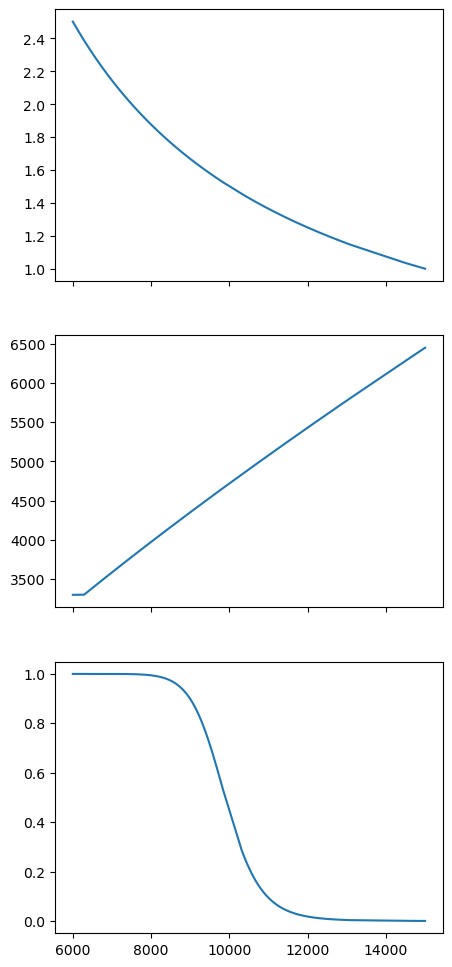

In [9]:
h = 6.626e-34 #SI 4.135e-15
kb = 1.38e-23 #SI
e     = 1.6e-19
eps_0 = 8.85e-12
m_e   = 9.1e-31
c     = 3e8

mu_beta = (10500-wl[(wl>6000) & (wl<15000)])/10500
t_obs = 1.43
t = t_obs/(1-mu_beta) 

T_phys = 4900 * (t/1.43)**(-0.77)
T_phys[T_phys<3300] = 3300
n_e = 1e9 * 1e6

lambda_debroglie = np.sqrt( h**2 / (2*np.pi*m_e * T_phys * kb) )
ni_over_n0 = 2*(lambda_debroglie)**(-3) * 2.01/1.01* np.exp( -5.7/(T_phys*8.61e-5) ) / n_e
rat_1 = (ni_over_n0/(1+ni_over_n0))

nii_over_ni = 2*(lambda_debroglie)**(-3) * 1/2 * np.exp( -11.03/(T_phys*8.61e-5) ) / n_e
rat_2 = (nii_over_ni/(1+nii_over_ni))
    
frac_2nd = ( rat_1*(1-np.array(rat_2)) )

fig, ax = plt.subplots( figsize=(5,12), nrows=3, sharex=True )

ax[0].plot(wl[(wl>6000) & (wl<15000)], t)
ax[1].plot(wl[(wl>6000) & (wl<15000)], T_phys)
ax[2].plot(wl[(wl>6000) & (wl<15000)], frac_2nd)

from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau_arr, lam, vref=0.2, ve=0.2, t0 = 120960): 
    
    y0 = []; y1 = []
    for wl_i, tau in zip(wl, tau_arr):
        prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
        cyg = prof_calc.calc_profile_Flam( npoints=50 )  
        
        inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)  
        #print(inter(wl_i))
        y1.append(inter(wl_i))
    
    #inter = interp1d(cyg[0].value*1e-10, y1, bounds_error=False, fill_value=1)    
    return np.array(y1) #inter(wl)

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=50 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)


#@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    

def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, tau2 = 0.0, lam2=7000, tau3=0.0, lam3 = 10000, logne=9, 
                    t_crit=1.43): #blackbody

    intensity = temp(wav, T)
    
    
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    #pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    #pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10500,vref=vref, ve=ve , t0=t0)

    #pcyg_prof_novel = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)
    #pcyg_prof_novel2 = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)
    
    
    mu_beta = (10500e-10-wav[(wav>6000e-10) & (wav<15000e-10)])/10830e-10
    t_obs = t_crit
    t = t_obs /(1-mu_beta)

    from scipy.interpolate import interp1d
    time        = np.linspace(0.5, 5.5, 100)
    #tau_in_time = (time/1.43)**2 *tau #
    #tau_in_time = np.ones_like(time)*tau
    #inter_polated_tau = interp1d(time, tau_in_time)

    #tau_in_time_arr = inter_polated_tau(t)

    pcyg_prof3 = p_cygni_line_corr(wav[(wav>6000e-10) & (wav<15000e-10)], v_out, v_phot, tau   , 10830, vref=vref, ve=ve , t0=t0)
#    pcyg_prof3 = p_cygni_line_corr(wav[(wav>6000e-10) & (wav<15000e-10)], v_out, v_phot, tau_in_time_arr   , 10830, vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3#*pcyg_prof4*pcyg_prof5#*pcyg_prof_novel*pcyg_prof_novel2

    #T_phys = 4100 * (t/ (t_obs+9.5/24) )**(-0.54) * (t_obs/t_crit)**(0.54)
    #T_phys[T_phys<3300] = 3300
    #n_e = 10**(logne) * 1e6

    #lambda_debroglie = np.sqrt( h**2 / (2*np.pi*m_e * T_phys * kb) )
    #ni_over_n0 = 2*(lambda_debroglie)**(-3) * 2.01/1.01* np.exp( -5.7/(T_phys*8.61e-5) ) / n_e
    #rat_1 = (ni_over_n0/(1+ni_over_n0))

    #nii_over_ni = 2*(lambda_debroglie)**(-3) * 1/2 * np.exp( -11.03/(T_phys*8.61e-5) ) / n_e
    #rat_2 = (nii_over_ni/(1+nii_over_ni))
    
    #frac_2nd = ( rat_1*(1-np.array(rat_2)) ) 
    

    #print( np.shape(correction), np.shape(intensity), np.shape(intensity[(wav>6000e-10) & (wav<15000e-10)]), correction ) 
    
    #print(T_phys)
    #print(frac_2nd)
    intensity[(wav>6000e-10) & (wav<15000e-10)] = (correction)*intensity[(wav>6000e-10) & (wav<15000e-10)]
        
    #T_phys_n = T * (t/ (t_obs*(1+vphot)) )**(-0.54)
    #flux_ratio = temp(wav[(wav>6000e-10) & (wav<15000e-10)],T_phys_n)/temp(wav[(wav>6000e-10) & (wav<15000e-10)], T)
    #correction[(wav>6000e-10) & (wav<15000e-10)] = 1 + (correction[(wav>6000e-10) & (wav<15000e-10)]-1)*flux_ratio
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    

    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity#*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    
    #logne = v["logne"]
    
    t_crit = v["t_crit"]
    #tau2, lam2 = v["tau2"], v["lam2"]
    #tau3, lam3 = v["tau3"], v["lam3"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2,  
                           t_crit=t_crit) #, 
                           #tau2=tau2, lam2=lam2, tau3=tau3, lam3=lam3)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Stuart_2.txt')
inter = interp1d(beta, doppler)
c = 3.0e+8
    
def lum_dist_arr(N, vphot, v_perp, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #v_perp, 1-2/3*11/10*vphot
    corr = delta#/inter2(vphot)**2#**4
        
    theta = 2*np.sqrt( N*10**(7) / corr ) #inverse
    v = v_perp*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc


n_days = [1.427, 2.417, 3.413, 4.403]

#plt.ylim(-1e-10, 1e-10)

Binning image by a factor: 10


((3300.0, 10000.0), None)

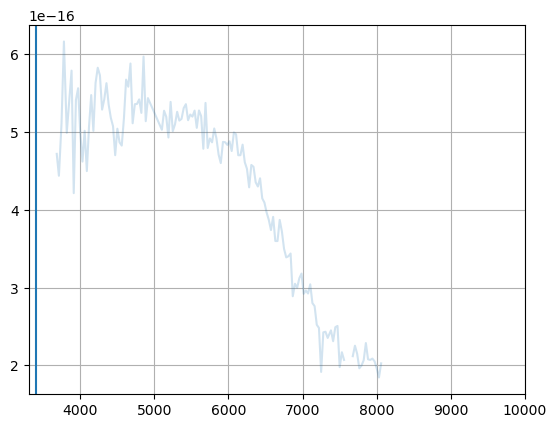

In [10]:
wl_SALT,f_SALT,fe_SALT = np.loadtxt('../Spectral Series (AT2017gfo)/SALT_Crawford.txt').T

exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) #&  (~((wav > 6800) & (wav < 6950))) 
wl_SALT, f_SALT, fe_SALT,_ = bin_spectrum(wl_SALT, f_SALT, fe_SALT, ~exc_reg, 10)
plt.plot(wl_SALT, f_SALT*10, '-', alpha=0.2)

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.31
p['ve'].value = 1
p['T'].value = 6300
p['occult'].value = 1
p['tau'].value = 3
#p.add_parameters('logne', 9)
#plt.plot(wli, residual(p, wli*1e-10), color='C2' )

#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)

plt.axvline(2600)
plt.axvline(3400)
#plt.xscale('log')
plt.xlim(3300, 10000), plt.grid()


Binning image by a factor: 20


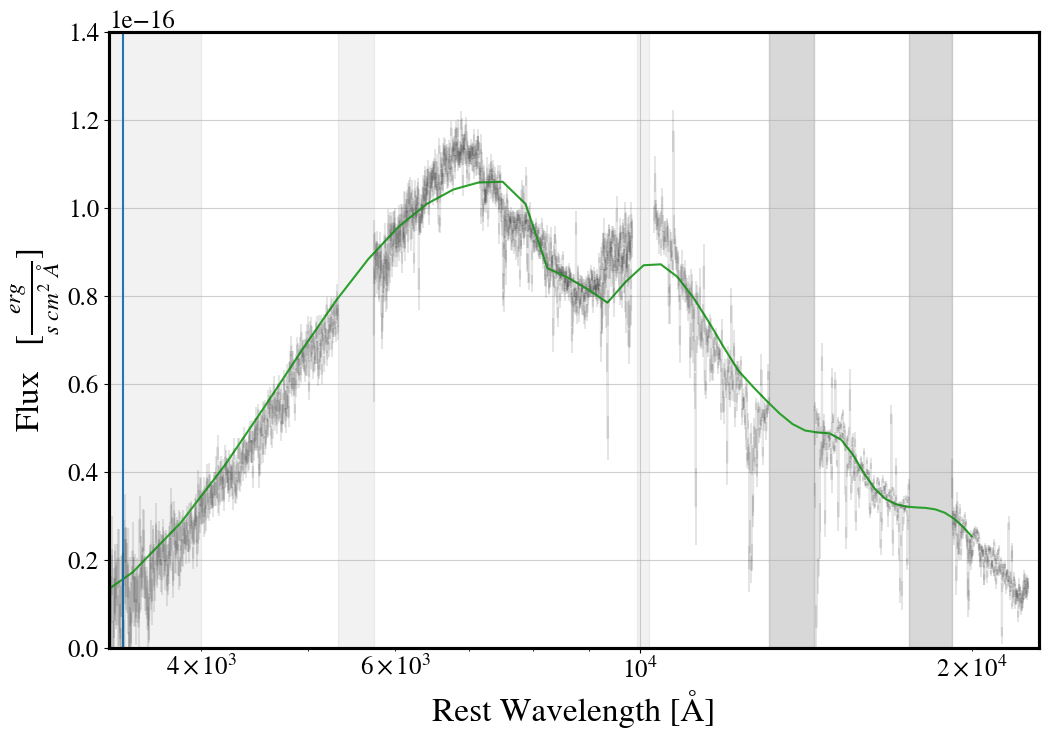

In [11]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = np.sort(os.listdir(path))

x = np.loadtxt(path+'/'+files[1]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500
#            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl_bin, f_bin, f_err_bin,_             = bin_spectrum(x[:,0], x[:,1], x[:,2], ~exc_reg_2, 20)
wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
error = error #* 2.26

reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
#plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.2)
plt.errorbar(wl_bin, f_bin, yerr=f_err_bin, label='X-shooter spectra', color='k', alpha=0.1)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 1.4e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 

wli = np.linspace(2000, 20000)

pickle_in = open("./data/OB2/OB2_3_peaks_with_gaussian_1.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=2.45, min=0, max=2)
p['ve'].value = 1
p['occult'].value = 1
p['tau'].value = 3
#p.add_parameters('logne', 9)
plt.plot(wli, residual(p, wli*1e-10), color='C2' )

#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)

plt.axvline(2600)
plt.axvline(3400)
plt.xscale('log')
#plt.savefig('Pictures/UV-extrapolation.png', dpi=300)

Binning image by a factor: 20


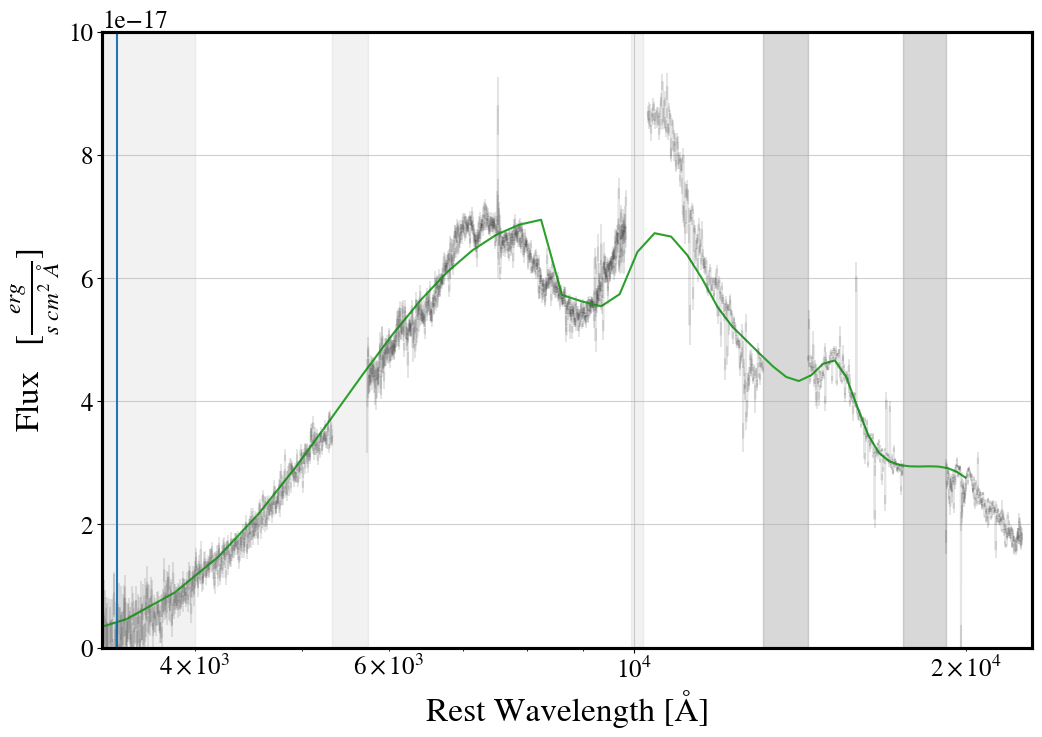

In [12]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = np.sort(os.listdir(path))

x = np.loadtxt(path+'/'+files[2]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500
#            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl_bin, f_bin, f_err_bin,_             = bin_spectrum(x[:,0], x[:,1], x[:,2], ~exc_reg_2, 20)
wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
error = error #* 2.26

reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
#plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.2)
plt.errorbar(wl_bin, f_bin, yerr=f_err_bin, label='X-shooter spectra', color='k', alpha=0.1)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 1e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 

wli = np.linspace(2000, 20000)

pickle_in = open("./data/OB3/OB3_3_peaks_with_gaussian.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.45, min=0, max=2)
p['ve'].value = 1
p['occult'].value = 1
p['tau'].value = 3
#p.add_parameters('logne', 9)
plt.plot(wli, residual(p, wli*1e-10), color='C2' )

#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)

plt.axvline(2600)
plt.axvline(3400)
plt.xscale('log')
#plt.savefig('Pictures/UV-extrapolation.png', dpi=300)

In [19]:
import astropy.io.fits as fits
#from dust_extinction.parameter_averages import F04
#from extinction import ccm89
import astropy.units as u

ext = F04(Rv=3.1)

#for f in fits.open('../Spectral Series (AT2017gfo)/ligo_oma_clfc2.fits'): 
for f in fits.open('../Spectral Series (AT2017gfo)/ligo_new1_eg21.fits'): 
    head = f.header
    data = f.data

wl_SALT = 2.919*np.arange(len(data))+1574
f_SALT  = data
#exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) &  (((wl_SALT > 3800) & (wl_SALT < 8700))) 
exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) &  (~((wl_SALT > 4880) & (wl_SALT < 5135))) &  (~((wl_SALT > 8170) & (wl_SALT < 8320))) & (((wl_SALT > 3800) & (wl_SALT < 8700))) 

wl_SALT,f_SALT,_,_ = bin_spectrum(wl_SALT,f_SALT,np.ones_like(f_SALT), ~exc_reg, 10)
plt.plot( wl_SALT, f_SALT, ds='steps', linewidth=1)

ext = F04(Rv=3.1)
reddening_n = ( ext.extinguish(wl_SALT*u.angstrom, Ebv=0.11))
f_SALT = f_SALT/reddening_n

plt.plot( wl_SALT , f_SALT, ds='steps', linewidth=1)
#plt.ylim(1e-18, 1e-16)
plt.xlim(3800, 11000)


NameError: name 'F04' is not defined

In [14]:
p

name,value,standard error,relative error,initial value,min,max,vary
T,3419.51847,1.39207513,(0.04%),3394.808999786545,2500.00000,7500.00000,True
N,3.6499e-29,8.3852e-32,(0.23%),3.817335296521477e-29,-inf,inf,True
vphot,0.20405328,2.6367e-04,(0.13%),0.20397601390780323,0.00000000,1.00000000,True
vmax,0.23313780,2.9810e-04,(0.13%),0.23304477038934446,0.00000000,1.00000000,True
t0,298800.000,,,298800,-inf,inf,False
tau,3.00000000,0.03167233,(1.06%),1.672403357135225,0.00000000,10.0000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,1.00000000,2.17166896,(217.17%),6.626496794247202,0.00000000,10.0000000,True
occult,1.00000000,0.03828228,(3.83%),3.5282757368413553,0.10000000,10.0000000,True
amp1,1.07909883,0.00595624,(0.55%),0.9692041656112941,0.01000000,5.00000000,True


In [18]:

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40; p['vphot'].value = 0.31; p['ve'].value = 1
p['T'].value = 6400
p['occult'].value = 1
p['tau'].value = tau_i/2
#p.add_parameters('logne', 9)
plt.plot(wli, residual(p, wli*1e-10)/(2e-17*norm)+ratio_off_set[2], color=get_darker(0.7, rtot[0]) )


NameError: name 'norm' is not defined

Binning image by a factor: 100
Binning image by a factor: 100
Binning image by a factor: 100
0.050000000000000044
0.07
0.07000000000000003


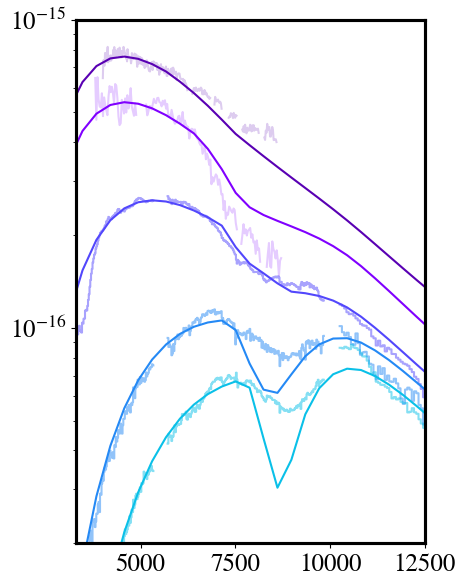

In [19]:
from astropy.io import ascii


def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rtot = rainbow_colors(11)

fig,ax = plt.subplots(figsize=(4.5,6.8))


filename = '../Spectral Series (AT2017gfo)/anufit_spectrum_dered.dat'
t = ascii.read(filename)
# Rename the columns
t.rename_column("col1", "wav"); t.rename_column("col2", "flux")
wav = t['wav'][:-7]; flux = t['flux'][:-7]
    
flux = np.reshape(flux, (int(np.shape(flux)[0]/15), 15) ); wav = np.reshape(wav, (int(np.shape(wav)[0]/15), 15) )
flux_ANU = np.mean(flux,axis=1); wav_ANU = np.mean(wav,axis=1)
exc_reg = (~((wav_ANU > 7550) & (wav_ANU < 7670))) &  (~((wav_ANU > 6850) & (wav_ANU < 6950))) &  (~((wav_ANU > 6250) & (wav_ANU < 6360)))  &  (~((wav_ANU > 7150) & (wav_ANU < 7320))) &  (~((wav_ANU > 8120) & (wav_ANU < 8250))) &  (wav_ANU < 8600) 
wav_ANU[~exc_reg], flux_ANU[~exc_reg] = np.nan, np.nan
plt.plot(wav_ANU, flux_ANU*2e-17, color=get_darker(0.7, rtot[0]), alpha=0.2)




##
#wl_SALT,f_SALT,fe_SALT = np.loadtxt('../Spectral Series (AT2017gfo)/SALT_Crawford.txt').T
#exc_reg = (~((wl_SALT > 7550) & (wl_SALT < 7670))) #&  (~((wav > 6800) & (wav < 6950))) 
#wl_SALT, f_SALT, fe_SALT,_ = bin_spectrum(wl_SALT, f_SALT, fe_SALT, ~exc_reg, 5)
plt.plot(wl_SALT, f_SALT*6,#, yerr = 10*fe_SALT, 
             color=get_darker(1, rtot[0]), alpha=0.2)


for i in [0, 1, 2]:
    x = np.loadtxt(path+'/'+files[i]).T
#x= np.array([wl, flux, error,error]).T
    exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500
#            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

    wl_bin, f_bin, f_err_bin,_             = bin_spectrum(x[:,0], x[:,1], x[:,2], ~exc_reg_2, 100)
    wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]
    error = error #* 2.26

    reset_plt(18,24)

    #plt.errorbar(wl_bin, f_bin, yerr=f_err_bin, label='X-shooter spectra', color=rtot[i+1], alpha=0.2)
    plt.plot(wl_bin, f_bin, label='X-shooter spectra', color=rtot[i+1], alpha=0.5, ds='steps')


tau_i = 1

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.50
p['vphot'].value = 0.31
p['T'].value = 6400
p['occult'].value = 1

p['tau'].max = 45*tau_i; 
p['tau'].value = 45*tau_i; 
p['ve'].value = 0.06; 


#p.add_parameters('logne', 9)
plt.plot(wli, 1.3*residual(p, wli*1e-10), color=get_darker(0.7, rtot[0]) )

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.30
p['T'].value = 6300

p['tau'].max = 140*tau_i; 
p['tau'].value = 140*tau_i; 
p['ve'].value = 0.06; 

#p.add_parameters('logne', 9)
plt.plot(wli, residual(p, wli*1e-10), color=get_darker(1, rtot[0]) )

pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.45, min=0, max=2)
p['ve'].value = 1
p['occult'].value = 1
p['vmax'].value = 0.34
p['vphot'].value = 0.29

p['tau'].max = 211; 
p['tau'].value = 211; 
p['ve'].value = 0.057; 
print( p['vmax'].value - p['vphot'].value)
plt.plot(wli, residual(p, wli*1e-10), color=rtot[1] )

pickle_in = open("./data/OB2/OB2_3_peaks_with_gaussian_1.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=2.45, min=0, max=2)
p['ve'].value = 1
p['occult'].value = 1
p['tau'].value = tau_i
p['amp1'].value = 0
p['vmax'].value = 0.32
p['vphot'].value = 0.25

p['tau'].max = 2698; 
p['tau'].value = 2698; 
p['ve'].value = 0.04;  

print( p['vmax'].value - p['vphot'].value)
plt.plot(wli, residual(p, wli*1e-10), color=rtot[2] )

pickle_in = open("./data/OB3/OB3_3_peaks_with_gaussian.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.45, min=0, max=2)
p['ve'].value = 1
p['occult'].value = 1
p['tau'].value = tau_i
p['amp1'].value = 0
p['vmax'].value = 0.28
p['vphot'].value = 0.21

p['tau'].max = 11366; 
p['tau'].value = 11366; 
p['ve'].value = 0.0325; 

print( p['vmax'].value - p['vphot'].value)
plt.plot(wli, residual(p, wli*1e-10), color=rtot[3] )


#plt.yscale('log'), plt.ylim(0.7e-16, 3e-16)
plt.ticklabel_format(axis='x', style='plain')
#plt.axvline(2600)
#plt.axvline(3400)
#plt.xscale('log')
plt.xlim(3300, 12500), plt.ylim(2e-17,1e-15)

plt.grid()
plt.yscale('log')

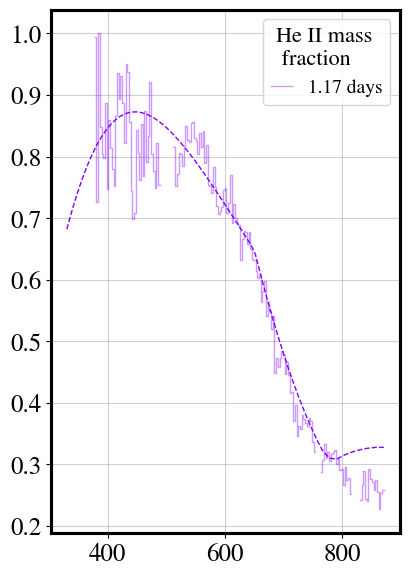

In [20]:
from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


fig,ax = plt.subplots(figsize=(4.5,6.8) )
ratio_off_set = np.zeros(10)
# SALT
ax.plot(wl_SALT/10 , f_SALT/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], #convolve(f_SALT, g8, fill_value=np.nan)*ratio_off_set[1]*6  , 
             color=get_darker(1, rtot[0]), ds='steps', label='1.17 days', alpha=0.4, linewidth=1)
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
p.add('t_crit', value=1.17, min=0, max=2)
p['vmax'].value = 0.40
p['vphot'].value = 0.29 #35
p['ve'].value = 1
p['T'].value = 6500
p['occult'].value = 1
p['tau'].value = tau_i

ax.plot( np.linspace( 330, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
                 0.15*residual(p, np.linspace( 330e-9, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
                color=get_darker(1, rtot[0]), linewidth=1, ls='--' )

p['tau'].value=0

plt.rcParams['legend.title_fontsize'] = 16
plt.legend(frameon=True, fontsize=14, handlelength=1.1, title='He II mass \n fraction')

#ax.plot( np.linspace( 330, max(wl_SALT[f_SALT==f_SALT])*1e-1, 1000 ), 
#                 0.135*residual(p, np.linspace( 330e-9, max(wl_SALT[f_SALT==f_SALT])*1e-10, 1000 ) )/np.max(f_SALT[f_SALT==f_SALT])+ratio_off_set[3], 
#                color=get_darker(1, rtot[0]), linewidth=0.5, ls='dotted' )


In [21]:
tau_i = 1
lw = 1

 
#tau0 8.511449673892583 ve 0.10153824315396923
#tau0 14.881208641411925 ve 0.10336911319636276
#tau0 158.74717669948572 ve 0.08320440099158784
#tau0 3823.0115238240032 ve 0.04695527357865939
#tau0 14283.029278754437 ve 0.036604130366884785
#tau0 22246.803792786897 ve 0.032136353482139245

tau_tot = [ 13.8 , 23.8, 287.2, 3823, 14283, 22246 ]
ve_tot  = [ 0.09, 0.09, 0.073, 0.0469, 0.036, 0.0321 ]

i=3
Binning image by a factor: 20
<Parameter 'T', value=3229.356686107796 +/- 1.86, bounds=[2500:7500]>


[Text(400, 0, '400'),
 Text(600, 0, '600'),
 Text(800, 0, '800'),
 Text(1000, 0, '1000'),
 Text(1400, 0, '1400'),
 Text(2000, 0, '2000')]

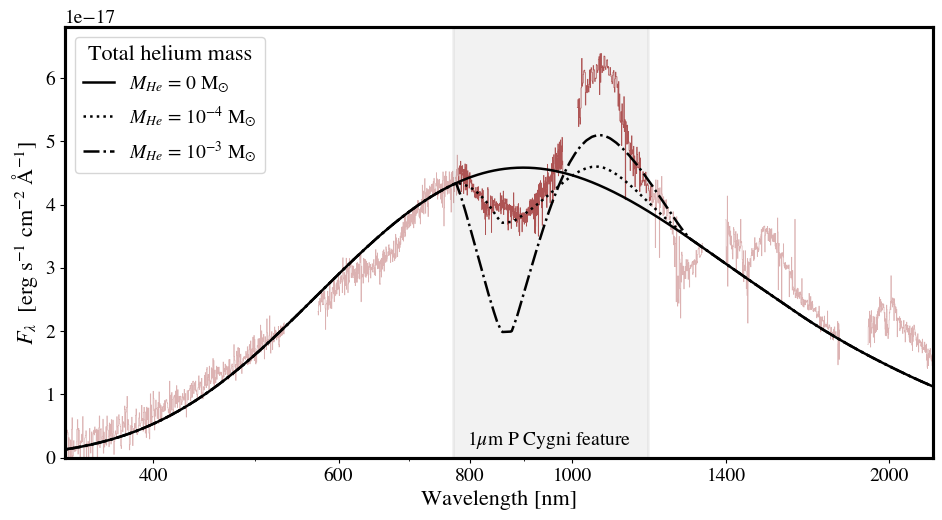

In [22]:
reset_plt(14, 18)

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(9.9,5.5) )
ax = axi['A']

#X-shooter
for i in [3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3300)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13300) & (wl < 14000)) | ((wl > 17950) & (wl < 19100))
    
    if (i==3): 
        print('i=3')
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        ax.plot(wl50/10, flux50,#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.3, ds='steps', linewidth=0.5)#, label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>7800) & (wl50<11900)]/10, flux50[(wl50>7800) & (wl50<11900)],#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.5, ds='steps', linewidth=0.5)
        
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        lw=1.8
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        print(p1['T'])
        
        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        p1['N'].value = 3.2e-29
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-', label = '$M_{He}$ = 0 M$_{\odot}$' )
#                color='k', linewidth=lw, ls='-', label = '$T_{BB}$ = 3200 K      $M_{He}$ = 0 M$_{\odot}$' )
        

        p1['tau'].max = tau_tot[4]*tau_i/50*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/50*1.2; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='dotted', label = '$M_{He}$ = 10$^{-4}$ M$_{\odot}$' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/5*1.2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-.', label = '$M_{He}$ = 10$^{-3}$ M$_{\odot}$' )
        
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='--', label = '100%' )
        
        p1['ve'].value = 1; 
        p1['tau'].max = 1; 
        p1['tau'].value = 1; 

#plt.text('')


import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  [erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=16)
plt.tight_layout()

plt.text(995-200, 0.2e-17, '1$\mu$m P Cygni feature', fontsize=14)
plt.fill_between([970-200, 970+210], [1e-16, 1e-16], lw=2, alpha=0.1, color='grey')
  
ax.set_xlim(330, 2200)#, 

#ax.axvline(800, ls='--', color='k')


ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength [nm]', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 16
plt.legend(frameon=True, fontsize=14, handlelength=1.6, loc=2, 
          title='Total helium mass')
#plt.title('Helium', fontsize=18)
#plt.title('Blackbody temperature; Total helium mass', fontsize=18)


plt.xscale('log')
ax.set_ylim(0, 6.8e-17)
ax.set_xticks([400, 600, 800, 1000, 1400, 2000])#
ax.set_xticklabels(['400', '600', '800', '1000', '1400', '2000'])


#axins.axvline(1045, color='k', alpha=0.3)

#plt.savefig('Pictures/He_feature_4days_1.pdf', dpi=300)


#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

i=3
Binning image by a factor: 20
<Parameter 'T', value=3229.356686107796 +/- 1.86, bounds=[2500:7500]>


[Text(0, 0.0, '0'),
 Text(0, 1e-17, '1'),
 Text(0, 2e-17, '2'),
 Text(0, 3e-17, '3'),
 Text(0, 4e-17, '4'),
 Text(0, 5e-17, '5'),
 Text(0, 6e-17, '6')]

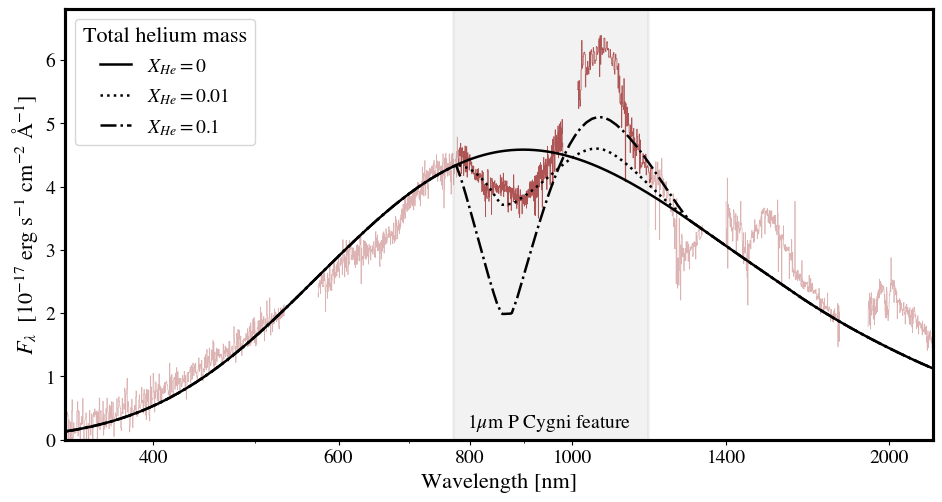

In [82]:
reset_plt(14, 18)

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(9.9,5.5) )
ax = axi['A']

#X-shooter
for i in [3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3300)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13300) & (wl < 14000)) | ((wl > 17950) & (wl < 19100))
    
    if (i==3): 
        print('i=3')
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        ax.plot(wl50/10, flux50,#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.3, ds='steps', linewidth=0.5)#, label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>7800) & (wl50<11900)]/10, flux50[(wl50>7800) & (wl50<11900)],#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.5, ds='steps', linewidth=0.5)
        
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        lw=1.8
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        print(p1['T'])
        
        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        p1['N'].value = 3.2e-29
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-', label = r'$X_{{He}} = 0$' )
#                color='k', linewidth=lw, ls='-', label = '$T_{BB}$ = 3200 K      $M_{He}$ = 0 M$_{\odot}$' )
        

        p1['tau'].max = tau_tot[4]*tau_i/50*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/50*1.2; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='dotted', label = r'$X_{{He}} = 0.01$' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/5*1.2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-.', label = r'$X_{He} = 0.1$' )
        
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='--', label = '100%' )
        
        p1['ve'].value = 1; 
        p1['tau'].max = 1; 
        p1['tau'].value = 1; 
        
        
        p1['vmax'].value = 0.30
        p1['vphot'].value = 0.18
        p1['N'].value = 3.2e-29
        
        p1['tau'].max = np.inf
        p1['tau'].value = 0
        p1['tau'].value = 20 * np.exp(0.15/0.04)
        p1['ve'].value = 0.04 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='darkblue', linewidth=lw, ls='-', label = '$M_{He}$ = 10$^{-4}$ M$_{\odot}$' )
        
        
        p1['tau'].max = np.inf
        p1['tau'].value = 0
        p1['tau'].value = 0.05 * np.exp(0.15/0.04)
        p1['ve'].value = 0.04 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='darkblue', linewidth=lw, ls='-', label = '$M_{He}$ = 10$^{-4}$ M$_{\odot}$' )
        
        

#plt.text('')


import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=16)
plt.tight_layout()

plt.text(995-200, 0.2e-17, '1$\mu$m P Cygni feature', fontsize=14)
plt.fill_between([970-200, 970+210], [1e-16, 1e-16], lw=2, alpha=0.1, color='grey')
  
ax.set_xlim(330, 2200)#, 

#ax.axvline(800, ls='--', color='k')


ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength [nm]', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 16
plt.legend(frameon=True, fontsize=14, handlelength=1.6, loc=2, 
          title='Total helium mass')
#plt.title('Helium', fontsize=18)
#plt.title('Blackbody temperature; Total helium mass', fontsize=18)


plt.xscale('log')
ax.set_ylim(0, 6.8e-17)
ax.set_xticks([400, 600, 800, 1000, 1400, 2000])#
ax.set_xticklabels(['400', '600', '800', '1000', '1400', '2000'])
ax.set_yticks([0, 1e-17, 2e-17, 3e-17, 4e-17, 5e-17, 6e-17])#
ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6'])


#axins.axvline(1045, color='k', alpha=0.3)

#plt.axvline(790)
#plt.axvline(960)
#plt.axvline(925)


#plt.savefig('Pictures/He_feature_4days_1.pdf', dpi=300)

#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

In [74]:
790/1083, 960/1083, 925/1083

(0.7294552169898431, 0.8864265927977839, 0.8541089566020313)

(array(0.30472099), array(0.12045663), array(0.16110885))

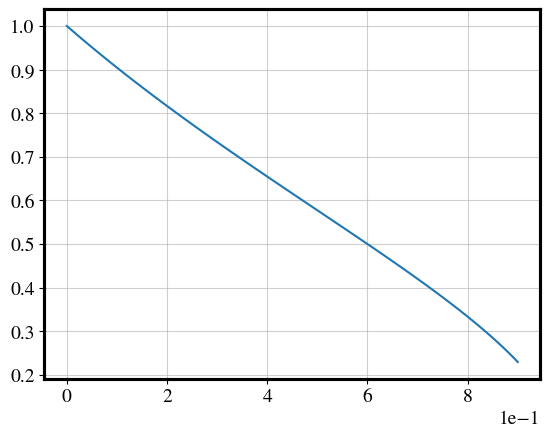

In [72]:
v = np.linspace(0, 0.9, 100)
delta = 1/(1+v)*np.sqrt(1-v**2)

plt.plot(v, delta)

from scipy.interpolate import interp1d

interp1d(delta, v)(0.73), interp1d(delta, v)(0.886), interp1d(delta, v)(0.85)

In [20]:
reset_plt(14, 18)

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(6.0,5.5) )
ax = axi['A']

#X-shooter
for i in [3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3300)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13300) & (wl < 14000)) | ((wl > 17950) & (wl < 19100))
    
    if (i==3): 
        print('i=3')
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        ax.plot(wl50/10, flux50,#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.3, ds='steps', linewidth=0.5)#, label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>7800) & (wl50<11900)]/10, flux50[(wl50>7800) & (wl50<11900)],#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.5, ds='steps', linewidth=0.5)
        
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        lw=1.8
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        print(p1['T'])
        
        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        #p1['vphot'].value = 0.17
        p1['N'].value = 3.2e-29
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-', label = '$M_{He}$ = 0 M$_{\odot}$' )
#                color='k', linewidth=lw, ls='-', label = '$T_{BB}$ = 3200 K      $M_{He}$ = 0 M$_{\odot}$' )
        

        p1['tau'].max = tau_tot[4]*tau_i/50*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/50*1.2; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='dotted', label = '$M_{He}$ = 10$^{-4}$ M$_{\odot}$' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/5*1.2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-.', label = '$M_{He}$ = 10$^{-3}$ M$_{\odot}$' )
        
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='--', label = '100%' )
        
        p1['ve'].value = 1; 
        p1['tau'].max = 1; 
        p1['tau'].value = 1; 
        
        
        p1['vmax'].value = 0.30
        p1['vphot'].value = 0.18
        p1['N'].value = 3.2e-29
        
        p1['tau'].max = np.inf
        p1['tau'].value = 0
        p1['tau'].value = 20 * np.exp(0.15/0.04)
        p1['ve'].value = 0.04 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='darkblue', linewidth=lw, ls='-', label = '$M_{He}$ = 10$^{-4}$ M$_{\odot}$' )
        
        
        p1['tau'].max = np.inf
        p1['tau'].value = 0
        p1['tau'].value = 0.05 * np.exp(0.15/0.04)
        p1['ve'].value = 0.04 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='darkblue', linewidth=lw, ls='-', label = '$M_{He}$ = 10$^{-4}$ M$_{\odot}$' )
        
        

#plt.text('')


import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=16)
plt.tight_layout()

#plt.text(995-200, 0.2e-17, '1$\mu$m P Cygni feature', fontsize=14)
plt.text(995-230, 0.2e-17, ' 1$\mu$m P Cygni \n feature', fontsize=14)
plt.fill_between([970-200, 970+220], [1e-16, 1e-16], lw=2, alpha=0.1, color='grey')
  
ax.set_xlim(330, 2200)#, 

#ax.axvline(800, ls='--', color='k')


ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength [nm]', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 16
plt.legend(frameon=True, fontsize=14, handlelength=1.6, loc=2, 
          title='Total helium mass')
#plt.title('Helium', fontsize=18)
#plt.title('Blackbody temperature; Total helium mass', fontsize=18)


plt.xscale('log')
ax.set_ylim(0, 6.8e-17)
ax.set_xticks([400, 600, 800, 1000, 1400, 2000])#
ax.set_xticklabels(['400', '600', '800', '1000', '1400', '2000'])
ax.set_yticks([0, 1e-17, 2e-17, 3e-17, 4e-17, 5e-17, 6e-17])#
ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6'])


#axins.axvline(1045, color='k', alpha=0.3)

#plt.savefig('Pictures/He_feature_4days_1_1panel.pdf', dpi=300)


#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

NameError: name 'wav_ANU' is not defined

i=3
Binning image by a factor: 20
<Parameter 'T', value=3229.356686107796 +/- 1.86, bounds=[2500:7500]>


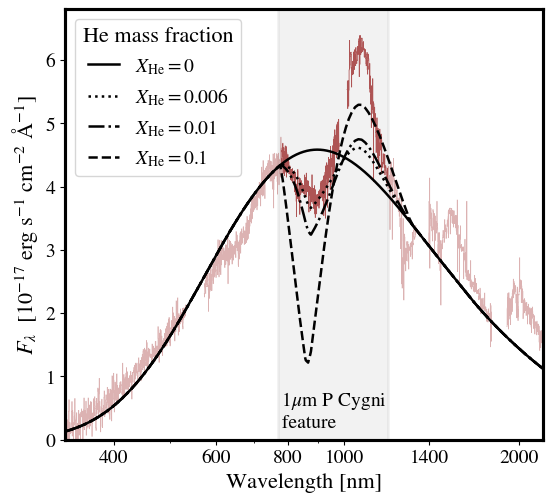

In [30]:
reset_plt(14, 18)

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(6.0,5.5) )
ax = axi['A']

#X-shooter
for i in [3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3300)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13300) & (wl < 14000)) | ((wl > 17950) & (wl < 19100))
    
    if (i==3): 
        print('i=3')
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        ax.plot(wl50/10, flux50,#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.3, ds='steps', linewidth=0.5)#, label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>7800) & (wl50<11900)]/10, flux50[(wl50>7800) & (wl50<11900)],#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.5, ds='steps', linewidth=0.5)
        
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        lw=1.8
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        print(p1['T'])
        
        
        p1['vmax'].value = 0.283
        #p1['vphot'].value = 0.21
        p1['vphot'].value = 0.194
        p1['N'].value = 3.2e-29
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-', label = r'$X_{\mathrm{He}} = 0$' )

        
        p1['tau'].max = tau_tot[4]*tau_i/50*1.2*0.6; 
        p1['tau'].value = tau_tot[4]*tau_i/50*1.2*0.6; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='dotted', label = r'$X_{\mathrm{He}} = 0.006$' )
        
        
        
        p1['tau'].max = tau_tot[4]*tau_i/50*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/50*1.2; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-.', label = r'$X_{\mathrm{He}} = 0.01$' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/5*1.2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='--', label = r'$X_{\mathrm{He}} = 0.1$' )
   
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='--', label = '100%' )
        
        p1['ve'].value = 1; 
        p1['tau'].max = 1; 
        p1['tau'].value = 1; 
        
        
        p1['vmax'].value = 0.30
        p1['vphot'].value = 0.18
        p1['N'].value = 3.2e-29
        
        p1['tau'].max = np.inf
        p1['tau'].value = 0
        p1['tau'].value = 20 * np.exp(0.15/0.04)
        p1['ve'].value = 0.04 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='darkblue', linewidth=lw, ls='-', label = '$M_{He}$ = 10$^{-4}$ M$_{\odot}$' )
        
        
        p1['tau'].max = np.inf
        p1['tau'].value = 0
        p1['tau'].value = 0.05 * np.exp(0.15/0.04)
        p1['ve'].value = 0.04 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='darkblue', linewidth=lw, ls='-', label = '$M_{He}$ = 10$^{-4}$ M$_{\odot}$' )
        
        

#plt.text('')


import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=16)
plt.tight_layout()

#plt.text(995-200, 0.2e-17, '1$\mu$m P Cygni feature', fontsize=14)
plt.text(995-230, 0.2e-17, ' 1$\mu$m P Cygni \n feature', fontsize=14)
plt.fill_between([970-200, 970+220], [1e-16, 1e-16], lw=2, alpha=0.1, color='grey')
  
ax.set_xlim(330, 2200)#, 

#ax.axvline(800, ls='--', color='k')


ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength [nm]', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 16
plt.legend(frameon=True, fontsize=14, handlelength=1.6, loc=2, 
          title='He mass fraction')
#plt.title('Helium', fontsize=18)
#plt.title('Blackbody temperature; Total helium mass', fontsize=18)


plt.xscale('log')
ax.set_ylim(0, 6.8e-17)
ax.set_xticks([400, 600, 800, 1000, 1400, 2000])#
ax.set_xticklabels(['400', '600', '800', '1000', '1400', '2000'])
ax.set_yticks([0, 1e-17, 2e-17, 3e-17, 4e-17, 5e-17, 6e-17])#
ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6'])


#axins.axvline(1045, color='k', alpha=0.3)

#plt.savefig('Pictures/He_feature_4days_1_1panel_Xhe_31oct.pdf', dpi=300)


#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

i=3
Binning image by a factor: 20


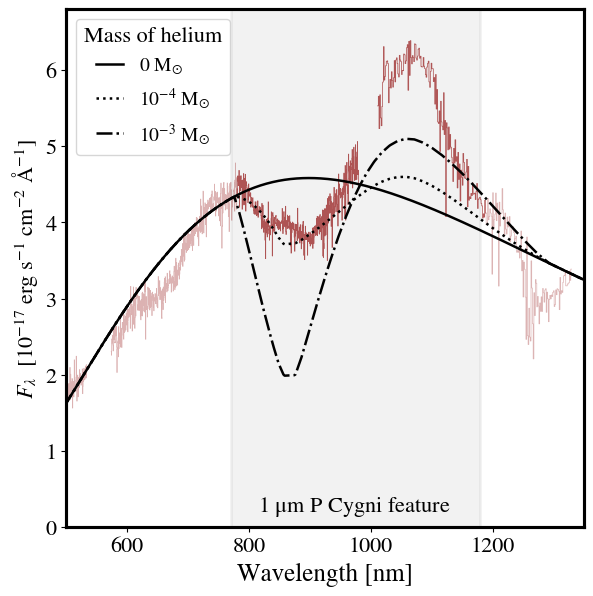

In [32]:
reset_plt(16, 20)

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit
p_ANU,_ = curve_fit(temp_n, wav_ANU[flux_ANU==flux_ANU]*1e-10, flux_ANU[flux_ANU==flux_ANU], p0=[6000, 1e-29*1e16])

p_SALT,_ = curve_fit(temp_n, wl_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)]*1e-10, f_SALT[(f_SALT==f_SALT) & (wl_SALT<6400) & (wl_SALT>4200)], p0=[6000, 1e-29])


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("A", figsize=(6.5,6.5) )
ax = axi['A']

#X-shooter
for i in [3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3300)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13300) & (wl < 14000)) | ((wl > 17950) & (wl < 19100))
    
    if (i==3): 
        print('i=3')
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        ax.plot(wl50/10, flux50,#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.3, ds='steps', linewidth=0.5)#, label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>7800) & (wl50<11900)]/10, flux50[(wl50>7800) & (wl50<11900)],#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.5, ds='steps', linewidth=0.5)
        
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        lw=1.8
        #p1['ve'].value = 1
        #p1['occult'].value = 1
        #p1['tau'].value = tau_i
        
        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        p1['N'].value = 3.2e-29
        
        p1['tau'].value = 0
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        #p1['vmax'].value = 0.26
        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-', label = '0 M$_{\odot}$' )
        

        p1['tau'].max = tau_tot[4]*tau_i/50*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/50*1.2; 
        p1['ve'].value = ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='dotted', label = '10$^{-4}$ M$_{\odot}$' )
        
        p1['tau'].max = tau_tot[4]*tau_i/5*1.2; 
        p1['tau'].value = tau_tot[4]*tau_i/5*1.2; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-.', label = '10$^{-3}$ M$_{\odot}$' )
        
        p1['tau'].max = tau_tot[4]*tau_i*2; 
        p1['tau'].value = tau_tot[4]*tau_i*2; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color='k', linewidth=lw, ls='--', label = '100%' )
        
        p1['ve'].value = 1; 
        p1['tau'].max = 1; 
        p1['tau'].value = 1; 

    
import matplotlib.ticker as mticker
#ax.set_ylabel(r'$F_{\lambda}$  [erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=18)
ax.set_ylabel(r'$F_{\lambda}$  [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=16)
plt.tight_layout()

plt.text(995-180, 0.2e-17, '1$\mathrm{ \mu}$m P Cygni feature', fontsize=16)
plt.fill_between([970-200, 970+210], [1e-16, 1e-16], lw=2, alpha=0.1, color='grey')
  
ax.set_xlim(330, 2200)#, 

#ax.axvline(800, ls='--', color='k')


ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength [nm]', fontsize=18)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 16
plt.legend(frameon=True, fontsize=14, handlelength=1.4, title='Mass of helium', loc=2)
#plt.title('Helium', fontsize=18)


#plt.xscale('log')
ax.set_ylim(0, 6.8e-17)
#ax.set_xticks([400, 600, 800, 1000, 1400, 2000])#
#ax.set_xticklabels(['400', '600', '800', '1000', '1400', '2000'])


#axins.axvline(1045, color='k', alpha=0.3)
plt.xlim(500, 1350)
ax.set_yticks([0, 1e-17, 2e-17, 3e-17, 4e-17, 5e-17, 6e-17])#
ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6'])

#plt.savefig('Pictures/He_feature_4days_1panel.pdf', dpi=300)


#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

In [37]:
p1

name,value,standard error,relative error,initial value,min,max,vary
T,3229.35669,1.86202876,(0.06%),3217.819292907171,2500.00000,7500.00000,True
N,3.2000e-29,1.0755e-31,(0.34%),3.2010461509524127e-29,-inf,inf,True
vphot,0.21000000,5.2321e-04,(0.25%),0.17304530867385287,0.00000000,1.00000000,True
vmax,0.28300000,4.0757e-04,(0.14%),0.2275609224257,0.00000000,1.00000000,True
t0,385200.000,,,385200,-inf,inf,False
tau,1.00000000,0.00550567,(0.55%),0.38361520428160834,0.00000000,1.00000000,True
vref,0.00000000,,,0.0,0.00000000,1.00000000,False
ve,1.00000000,1.77601098,(177.60%),7.104226961196531,0.00000000,10.0000000,True
occult,8.15231253,0.10853579,(1.33%),7.656267982349197,0.10000000,20.0000000,True
amp1,0.01000000,0.00545736,(54.57%),0.9278409771344276,0.01000000,5.00000000,True


In [43]:
(4.4/1.5)**3 /  (0.2/0.3)**(-2), (4.4/1.5)**3 / (0.2/0.3)**(-5)

(11.217646090534984, 3.323746989788145)

In [39]:
#1e8 * 
(0.2/0.3)**(-5), (0.2/0.3)**(-3), (0.2/0.3)**(-2)

(7.593749999999996, 3.3749999999999987, 2.2499999999999996)

In [24]:
v = 0.22
print( 'Classical', 1040 * (1-v) )

Classical 811.2


In [25]:
v = 0.25
print( 'Classical', 1083 * (1-v) )

v = 0.28
1083 * (1-v) / np.sqrt(1-v**2)

Classical 812.25


812.25

In [44]:
(4.4/1.5)**3

25.23970370370371

In [45]:
1e8/3.3

30303030.303030305

i=3
Binning image by a factor: 20
i=3
Binning image by a factor: 20
i=3
Binning image by a factor: 20


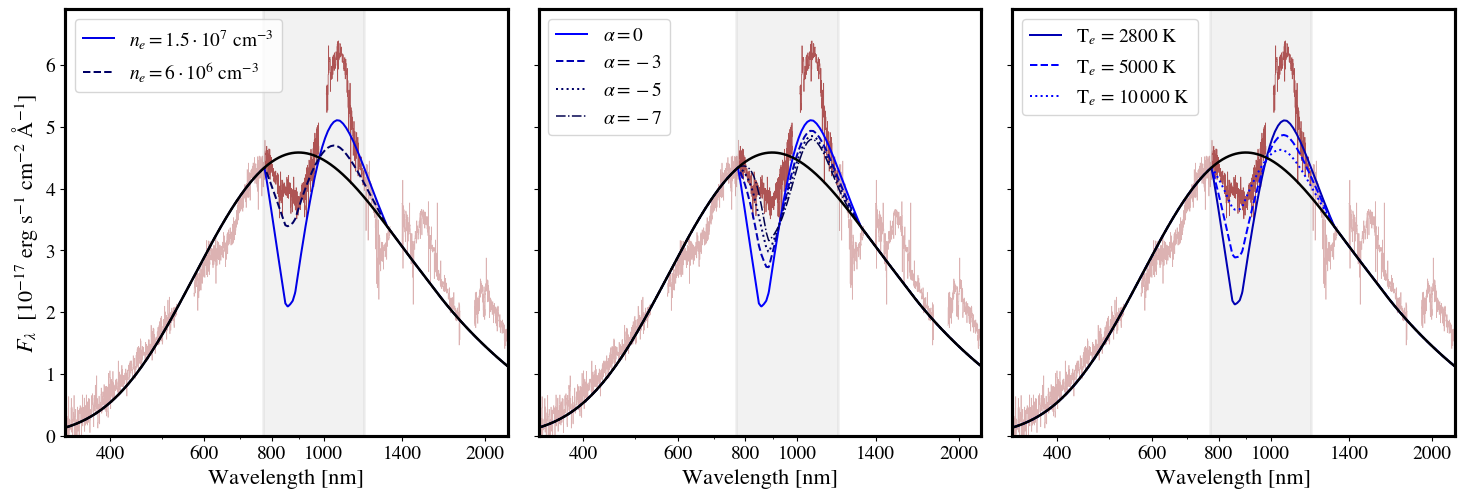

In [53]:
tau_tot = [ 13.8 , 23.8, 287.2, 3823, 14283, 22246 ]
ve_tot  = [ 0.09, 0.09, 0.073, 0.0469, 0.036, 0.0321 ]

#644.2420978781983 ve 0.18182501809951399


reset_plt(14, 18)

def temp_n(wav,T,N):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return N*a/ ( (wav**5)*(np.exp(b) - 1.0) )


from scipy.optimize import curve_fit


from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g10 = Gaussian1DKernel(stddev=10)
g40 = Gaussian1DKernel(stddev=40)
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g1 = Gaussian1DKernel(stddev=1)
g2 = Gaussian1DKernel(stddev=2)
g3 = Gaussian1DKernel(stddev=4)
g8 = Gaussian1DKernel(stddev=8)

def rainbow_colors(num_colors):
    rainbow = plt.get_cmap('rainbow') #rainbow
    return [rainbow(i/num_colors) for i in range(num_colors)]
def get_darker(alpha, color):
    return [ alpha*color[i] for i in range(3) ]

rotation=0
fontsize=12

rtot = rainbow_colors(11)
r = rtot[1:]
#r = r + [get_darker(0.7, rtot[-1])] #+ [get_darker(0.6, rtot[-1])]
r_HST = r[4]
#r_HST2 = r[-2]
r = r[:4] + r[5:]#-2] + [r[-1]]


#fig, ax2 = plt.subplots( figsize=(11,6), ncols=2 )
#ax = ax2[0]
#axins = ax2[1]

off_sets = np.linspace(-0.2,2.1,5)[::-1]

fig,axi = plt.subplot_mosaic("ABC", figsize=(15.0,5.5))#, sharex=True)
ax = axi['A']

tau_i = 0.66 #5*0.66 #0.66
#tau_i = 3.0#*0.66 #0.66
#tau_i = 2.0#*0.66 #0.66

#X-shooter
for i in [3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3300)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13300) & (wl < 14000)) | ((wl > 17950) & (wl < 19100))
    
    if (i==3): 
        print('i=3')
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        ax.plot(wl50/10, flux50,#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.3, ds='steps', linewidth=0.5)#, label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>7800) & (wl50<11900)]/10, flux50[(wl50>7800) & (wl50<11900)],#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.5, ds='steps', linewidth=0.5)
        
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        lw=1.8        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        p1['vphot'].value = 0.185
        p1['N'].value = 3.2e-29
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
    
        p1['tau'].max = 2165*tau_i/100; 
        p1['tau'].value = 2165*tau_i/100; 
        p1['ve'].value = 0.130 #ve_tot[4]; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color=[0, 0, 1], linewidth=0.8*lw, ls='-', label = '$n_e=4\cdot 10^{7}$ cm$^{-3}$' )

        
        p1['tau'].max = 644*tau_i/100; 
        p1['tau'].value = 644*tau_i/100; 
        p1['ve'].value = 0.1818 #ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=[0, 0, 0.9], linewidth=0.8*lw, ls='-', label = '$n_e=1.5\cdot 10^{7}$ cm$^{-3}$' )

        
        p1['tau'].max = 139*tau_i/100; 
        p1['tau'].value = 139*tau_i/100; 
        p1['ve'].value = 0.278 #ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=[0, 0, 0.4], linewidth=0.8*lw, ls='--', label = '$n_e=6\cdot 10^{6}$ cm$^{-3}$' )

        

        
        p1['tau'].value = 0

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-')#, label = r'Blackbody, T$_{BB}$=3200 K' )



import matplotlib.ticker as mticker
ax.set_ylabel(r'$F_{\lambda}$  [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=16)
plt.tight_layout()

#plt.text(995-200, 0.2e-17, '1$\mu$m P Cygni feature', fontsize=14)
#ax.text(995-230, 0.2e-17, ' 1$\mu$m P Cygni \n feature', fontsize=14)
ax.fill_between([970-200, 970+220], [1e-16, 1e-16], lw=2, alpha=0.1, color='grey')
  
ax.set_xlim(330, 2200)#, 

#ax.axvline(800, ls='--', color='k')


ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength [nm]', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 16
ax.legend(frameon=True, fontsize=14, handlelength=1.6, loc=2, 
         )#title='He mass fraction')
#plt.title('Helium', fontsize=18)
#plt.title('Blackbody temperature; Total helium mass', fontsize=18)


ax.set_xscale('log')
ax.set_ylim(0, 6.9e-17)
ax.set_xticks([400, 600, 800, 1000, 1400, 2000])#
ax.set_xticklabels(['400', '600', '800', '1000', '1400', '2000'])
ax.set_yticks([0, 1e-17, 2e-17, 3e-17, 4e-17, 5e-17, 6e-17])#
ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6'])


#correction = 139/

#tau_i = 1

ax = axi['B']

#X-shooter
for i in [3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3300)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13300) & (wl < 14000)) | ((wl > 17950) & (wl < 19100))
    
    if (i==3): 
        print('i=3')
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        ax.plot(wl50/10, flux50,#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.3, ds='steps', linewidth=0.5)#, label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>7800) & (wl50<11900)]/10, flux50[(wl50>7800) & (wl50<11900)],#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.5, ds='steps', linewidth=0.5)
        
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        lw=1.8        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.21
        p1['vphot'].value = 0.185#0.194
        p1['N'].value = 3.2e-29
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        
        
        #107463.92020283453 ve 0.032223714889041195
        
        
        p1['tau'].max   = 644*tau_i/100; 
        p1['tau'].value = 644*tau_i/100; 
        p1['ve'].value  = 0.1818 #ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=[0, 0, 1], linewidth=0.8*lw, ls='-', label = r'$\alpha= 0$' )

        #11528.797432101108 ve 0.05044152284420776
        
        p1['tau'].max   = 11528*tau_i/100; 
        p1['tau'].value = 11528*tau_i/100; 
        p1['ve'].value  = 0.05 #ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=[0, 0, 0.7], linewidth=0.8*lw, ls='--', label = r'$\alpha=-3$' )
        
    
    
        p1['tau'].max   = 107463*tau_i/100; 
        p1['tau'].value = 107463*tau_i/100; 
        p1['ve'].value  = 0.0322 #ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=[0, 0, 0.4], linewidth=0.8*lw, ls='dotted', label = r'$\alpha=-5$' )

        #p1['vphot'].value = 0.18

        p1['tau'].max   = 417875.6671416243*tau_i/10  # 757463*tau_i/100; 
        p1['tau'].value = 417875.6671416243*tau_i/10; 
        p1['ve'].value  = 0.020595924568910576 #0.0305 #ve_tot[4]; 


        #p1['tau'].max   = 2236435.6671416243*tau_i/10  # 757463*tau_i/100; 
        #p1['tau'].value = 2236435.6671416243*tau_i/10; 
        #p1['ve'].value  = 0.017563271479201217 #0.0305 #ve_tot[4]; 

        #p1['tau'].max   = 67477.42697301312*tau_i/10  # 757463*tau_i/100; 
        #p1['tau'].value = 67477.42697301312*tau_i/10; 
        #p1['ve'].value  = 0.01756408308633092 #0.0305 #ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=[0, 0, 0.3], linewidth=0.6*lw, ls='-.', label = r'$\alpha=-7$' )
        
        
        #644.2420978781983 ve 0.1818
        #tau0 1331.481561308458 ve 0.10965593882764718

        p1['tau'].max   = 1331*tau_i/100; 
        p1['tau'].value = 1331*tau_i/100; 
        p1['ve'].value  = 0.109 #ve_tot[4]; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color=[0, 0, 0.7], linewidth=0.8*lw, ls='-', label = r'$\alpha=-1$' )

        
        p1['tau'].value = 0

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-')#, label = r'Blackbody, T$_{BB}$=3200 K' )



import matplotlib.ticker as mticker
#ax.set_ylabel(r'$F_{\lambda}$  [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=16)
plt.tight_layout()

#plt.text(995-200, 0.2e-17, '1$\mu$m P Cygni feature', fontsize=14)
#ax.text(995-230, 0.2e-17, ' 1$\mu$m P Cygni \n feature', fontsize=14)
ax.fill_between([970-200, 970+220], [1e-16, 1e-16], lw=2, alpha=0.1, color='grey')
  
ax.set_xlim(330, 2200)#, 

#ax.axvline(800, ls='--', color='k')


ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength [nm]', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 16
ax.legend(frameon=True, fontsize=14, handlelength=1.6, loc=2, 
         )#title='He mass fraction')
#plt.title('Helium', fontsize=18)
#plt.title('Blackbody temperature; Total helium mass', fontsize=18)


ax.set_xscale('log')
ax.set_ylim(0, 6.9e-17)
ax.set_xticks([400, 600, 800, 1000, 1400, 2000])#
ax.set_xticklabels(['400', '600', '800', '1000', '1400', '2000'])
ax.set_yticks([0, 1e-17, 2e-17, 3e-17, 4e-17, 5e-17, 6e-17])#
ax.set_yticklabels(['', '', '', '', '', '', ''])





ax = axi['C']

#X-shooter
for i in [3]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3300)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9800) & (wl < 10120)) | ((wl > 13300) & (wl < 14000)) | ((wl > 17950) & (wl < 19100))
    
    if (i==3): 
        print('i=3')
        wl50, flux50, error50,_ = bin_spectrum(wl2, flux2, error2, mask, 20)

        ax.plot(wl50/10, flux50,#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.3, ds='steps', linewidth=0.5)#, label=str(i+1.4)+' days', linewidth=1)
        
        ax.plot(wl50[(wl50>7800) & (wl50<11900)]/10, flux50[(wl50>7800) & (wl50<11900)],#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
                 color='darkred' , alpha=0.5, ds='steps', linewidth=0.5)
        
        #ax.plot(wl50[(wl50>10450*0.57) & (wl50<10450*1.12)]/10, flux50[(wl50>10450*0.57) & (wl50<10450*1.12)]/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], #(convolve(flux2, g40, fill_value=np.nan)*ratio_off_set[i+3]), 
         #        color=r[i] , alpha=1, ds='steps', linewidth=1)
        
        pickle_in = open('./data/OB4/OB4_3_peaks_with_gaussian.pkl',"rb") #OB1_3_peaks_100walkers
        emcee_res = pickle.load(pickle_in)
        p1 = emcee_res.params
        p1.add('t_crit', value=1.45, min=0, max=2)
        
        lw=1.8        
        p1['vmax'].value = 0.283
        p1['vphot'].value = 0.185#0.194
        #p1['vphot'].value = 0.195
        p1['N'].value = 3.2e-29
        p1['amp1'].value = 0
        p1['amp2'].value = 0
        
        
        
        #tau0 150782.17429568004 ve 0.026040466400716913
    
        #tau0 2026.6024672406568 ve 0.15016187540891207
        p1['tau'].max   = 2026*tau_i/100; 
        p1['tau'].value = 2026*tau_i/100; 
        p1['ve'].value  = 0.15 #ve_tot[4]; 

        #ax.plot( np.linspace( 330, 2300, 1000 ), 
        #         residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
        #        color=[0.0, 0, 0.4], linewidth=0.8*lw, ls='-', label = r'T$_e$ = 1000 K' )

    
        #tau0 834.0027652470666 ve 0.15032589613706576

        p1['tau'].max   = 834*tau_i/100; 
        p1['tau'].value = 834*tau_i/100; 
        p1['ve'].value  = 0.1503 #ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=[0.0, 0, 0.7], linewidth=0.8*lw, ls='-', label = r'T$_e$ = 2800 K' )

        #11528.797432101108 ve 0.05044152284420776
        #tau0 466.07667242896224 ve 0.15037622541283127

    
        p1['tau'].max   = 466.07*tau_i/100; 
        p1['tau'].value = 466.07*tau_i/100; 
        p1['ve'].value  = 0.1503 #ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=[0, 0, 1], linewidth=0.8*lw, ls='--', label = r'T$_e$ = 5000 K' )
        
        p1['tau'].max   = 215.07*tau_i/100; 
        p1['tau'].value = 215.07*tau_i/100; 
        p1['ve'].value  = 0.1503 #ve_tot[4]; 

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ), #/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color=[0, 0, 1], linewidth=0.8*lw, ls='dotted', label = r'T$_e$ = 10$\,$000 K' )
        
        
        

        
        p1['tau'].value = 0

        ax.plot( np.linspace( 330, 2300, 1000 ), 
                 residual(p1, np.linspace( 330e-9, 2300e-9, 1000 ) ),#/np.max(flux50[flux50==flux50])+ratio_off_set[i+4], 
                color='k', linewidth=lw, ls='-')#, label = r'Blackbody, T$_{BB}$=3200 K' )



import matplotlib.ticker as mticker
#ax.set_ylabel(r'$F_{\lambda}$  [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]', fontsize=16)
plt.tight_layout()

#plt.text(995-200, 0.2e-17, '1$\mu$m P Cygni feature', fontsize=14)
#ax.text(995-230, 0.2e-17, ' 1$\mu$m P Cygni \n feature', fontsize=14)
ax.fill_between([970-200, 970+220], [1e-16, 1e-16], lw=2, alpha=0.1, color='grey')
  
ax.set_xlim(330, 2200)#, 

#ax.axvline(800, ls='--', color='k')


ax.grid()
ax.ticklabel_format(axis='x', style='plain')
ax.set_xlabel('Wavelength [nm]', fontsize=16)
#plt.yscale('log')
plt.rcParams['legend.title_fontsize'] = 16
ax.legend(frameon=True, fontsize=14, handlelength=1.6, loc=2, 
         )#title='He mass fraction')
#plt.title('Helium', fontsize=18)
#plt.title('Blackbody temperature; Total helium mass', fontsize=18)


ax.set_xscale('log')
ax.set_ylim(0, 6.9e-17)
ax.set_xticks([400, 600, 800, 1000, 1400, 2000])#
ax.set_xticklabels(['400', '600', '800', '1000', '1400', '2000'])
ax.set_yticks([0, 1e-17, 2e-17, 3e-17, 4e-17, 5e-17, 6e-17])#
ax.set_yticklabels(['', '', '', '', '', '', ''])

#plt.adjust_hspace(0.05)
#axins.axvline(1045, color='k', alpha=0.3)
plt.subplots_adjust(wspace=0.07)


#plt.savefig('Pictures/He_feature_4days_3panel_dependencies_Xhe1_feb5_Xhe1.pdf', dpi=300)


#plt.savefig('Pictures/Big_spectral_series_linlin_velocity_4panel-uniform_dust.pdf', dpi=300)

In [128]:
1.5/0.6 * 1.5

3.75

In [211]:


644 * np.exp(-0.21/0.1818), 139 * np.exp(-0.21/0.28)


(202.8736181659602, 65.65895083100105)

In [212]:
202.8736181659602 /  65.6

3.092585642773784